## Binary MNIST
We obtained a binary MNIST dataset by thresholding original MNIST with a threshold $0.3$. Below we provide samples and interpolation. If you want to reproduce the models, run the following commands:
* `python train.py --config configs/mnist/U_U.ini --device cuda:0`
* `python train.py --config configs/mnist/N_N.ini --device cuda:0`


In [1]:
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

from dd_vae.vae_mnist import VAE_MNIST
from dd_vae.utils import prepare_seed

%matplotlib inline

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.3).float())
])
train_dataset = MNIST('data/mnist', train=True, download=True, transform=transform)
test_dataset = MNIST('data/mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [3]:
def convert(img, mode='argmax'):
    if mode == 'sample':
        if isinstance(img, np.ndarray):
            return np.random.rand(*img.shape) < img
        else:
            return (torch.rand(*img.shape).to(img.device) < img).float()
    elif mode == 'argmax':
        return img > 0.5
    else:
        return img

In [4]:
def grid(model_path, img_path=None, mode='argmax', k=10, d=1, gap=5):
    model = VAE_MNIST.load(model_path)
    prepare_seed()
    z = np.array([(j, -i) for i in np.linspace(-d, d, k) for j in np.linspace(-d, d, k)])
    x = model.sample(z=torch.tensor(z).float()).detach().numpy()
    fig = plt.figure(figsize=(5, 5))
    img = np.ones(((28 + gap) * k - gap, (28 + gap) * k - gap))
    for i in range(k*k):
        a = i // k
        b = i % k
        l = a * (28 + gap)
        t = b * (28 + gap)
        img[l:l+28, t:t+28] = convert(x[i][0], mode)
    plt.imshow(img, cmap=plt.cm.Greys_r, extent=[-d, d, -d, d])
    if img_path is not None:
        plt.tight_layout()
        plt.savefig(img_path, dpi=250)
    plt.show()

def latent(model_path, img_path=None):
    prepare_seed()
    model = VAE_MNIST.load(model_path)
    mu = []
    std = []
    labels = []

    for x, _y in tqdm(test_loader):
        labels.append(_y)
        m, s =  model.get_mu_std(model.encoder(x))
        mu.append(m.detach().cpu().numpy())
        std.append(s.detach().cpu().numpy())

    mu = np.row_stack(mu)
    std = np.row_stack(std)
    labels = np.concatenate(labels)
    s = np.random.randn(*mu.shape) * std + mu
    for i in range(10):
        idx = (labels == i)
        plt.scatter(s[idx][:, 0], s[idx][:, 1], s=20, marker='o', label=i, alpha=0.3)
    plt.legend()
    if img_path is not None:
        plt.tight_layout()
        plt.savefig(img_path, dpi=250)
    plt.show()

def knn(model_path):
    model = VAE_MNIST.load(model_path)
    X, y = zip(*[(model.encode(batch).cpu().detach().numpy(), batch[1].numpy()) for batch in train_loader])
    X = np.row_stack(X)
    y = np.concatenate(y)
    X_test, y_test = zip(*[(model.encode(batch).cpu().detach().numpy(), batch[1].numpy()) for batch in test_loader])
    X_test = np.row_stack(X_test)
    y_test = np.concatenate(y_test)

    best_test_accuracy = 0
    for p in [1, 2]:
        for n_neighbors in [10, 15, 20, 25, 30, 35, 40]:
            m = KNeighborsClassifier(n_neighbors=n_neighbors, p=p).fit(X, y)
            best_test_accuracy = max(best_test_accuracy, (m.predict(X_test) == y_test).mean())
    return best_test_accuracy

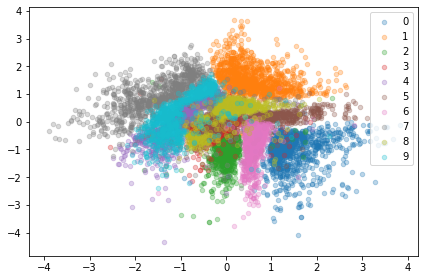

In [5]:
latent('models/mnist/N_N/checkpoint.pt', 'images/mnist/latent_N_N.png')

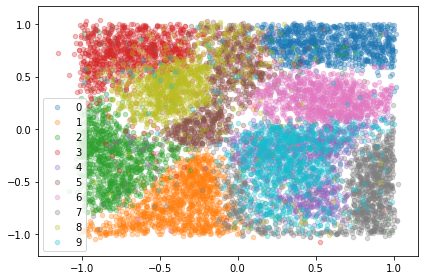

In [6]:
latent('models/mnist/U_U/checkpoint.pt', 'images/mnist/latent_U_U.png')

In [7]:
knn('models/mnist/U_U/checkpoint.pt')

0.8776

In [8]:
knn('models/mnist/N_N/checkpoint.pt')

0.8612